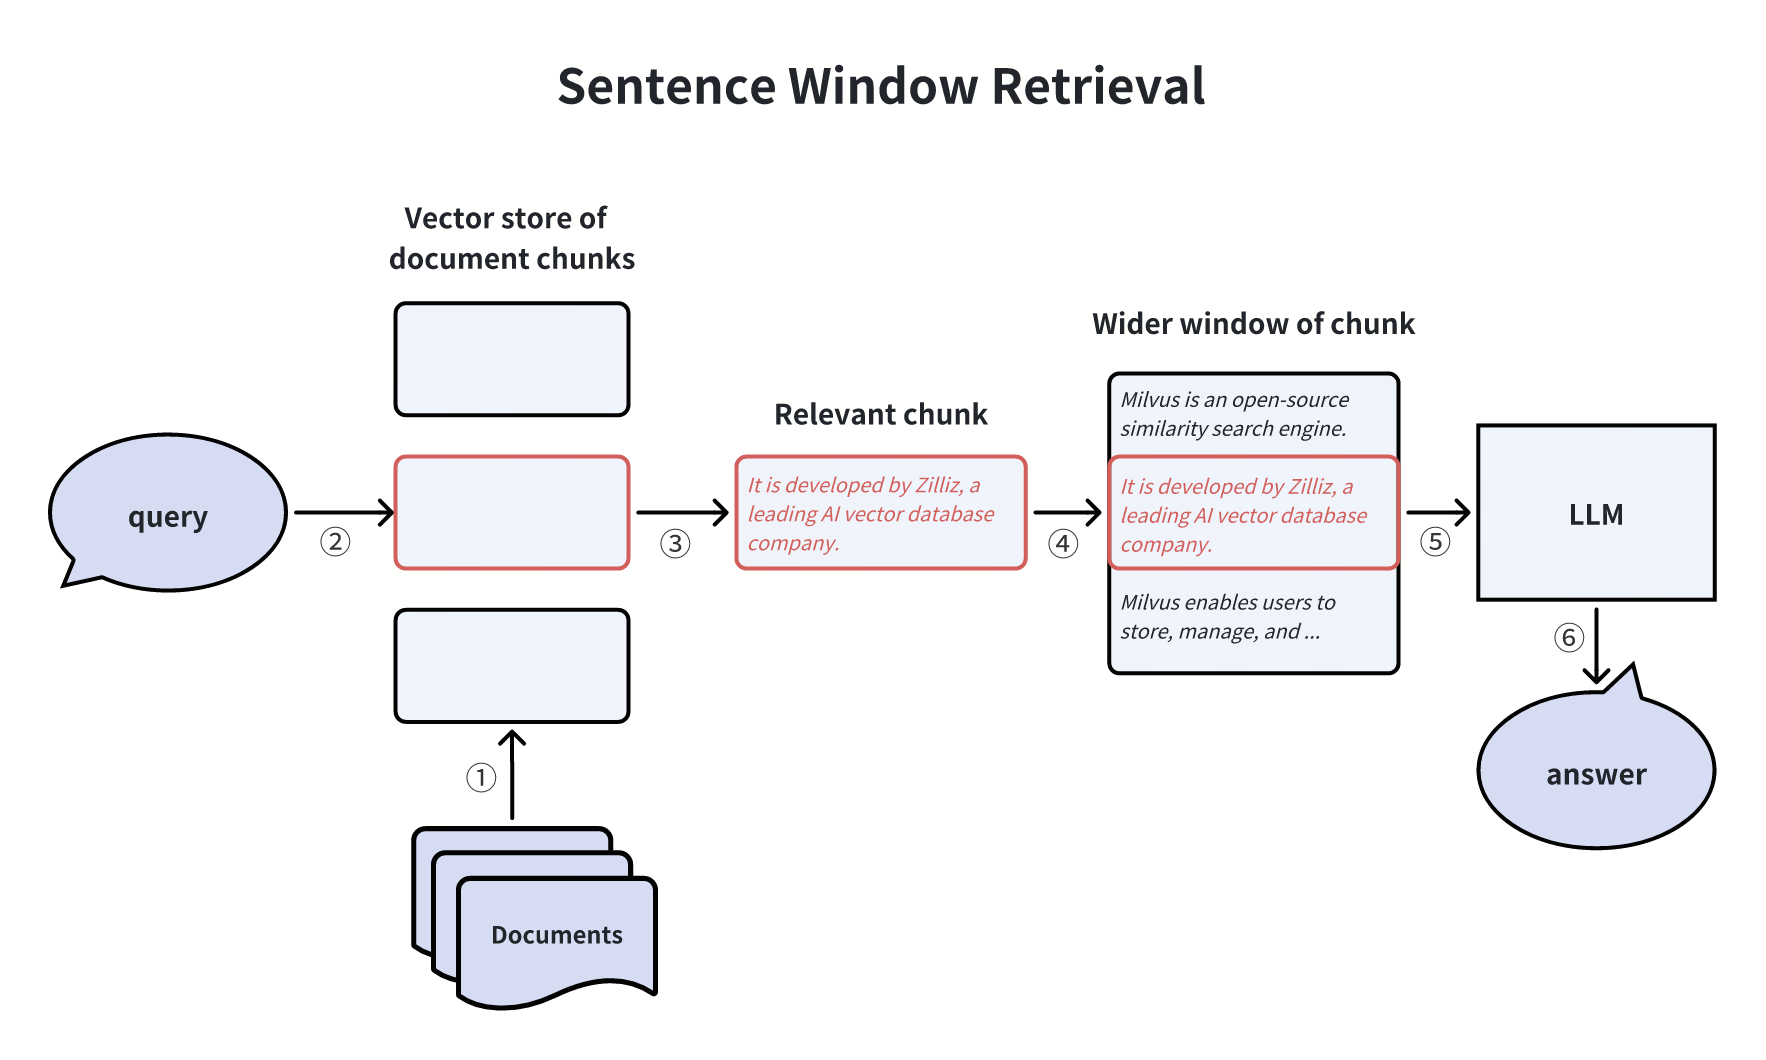

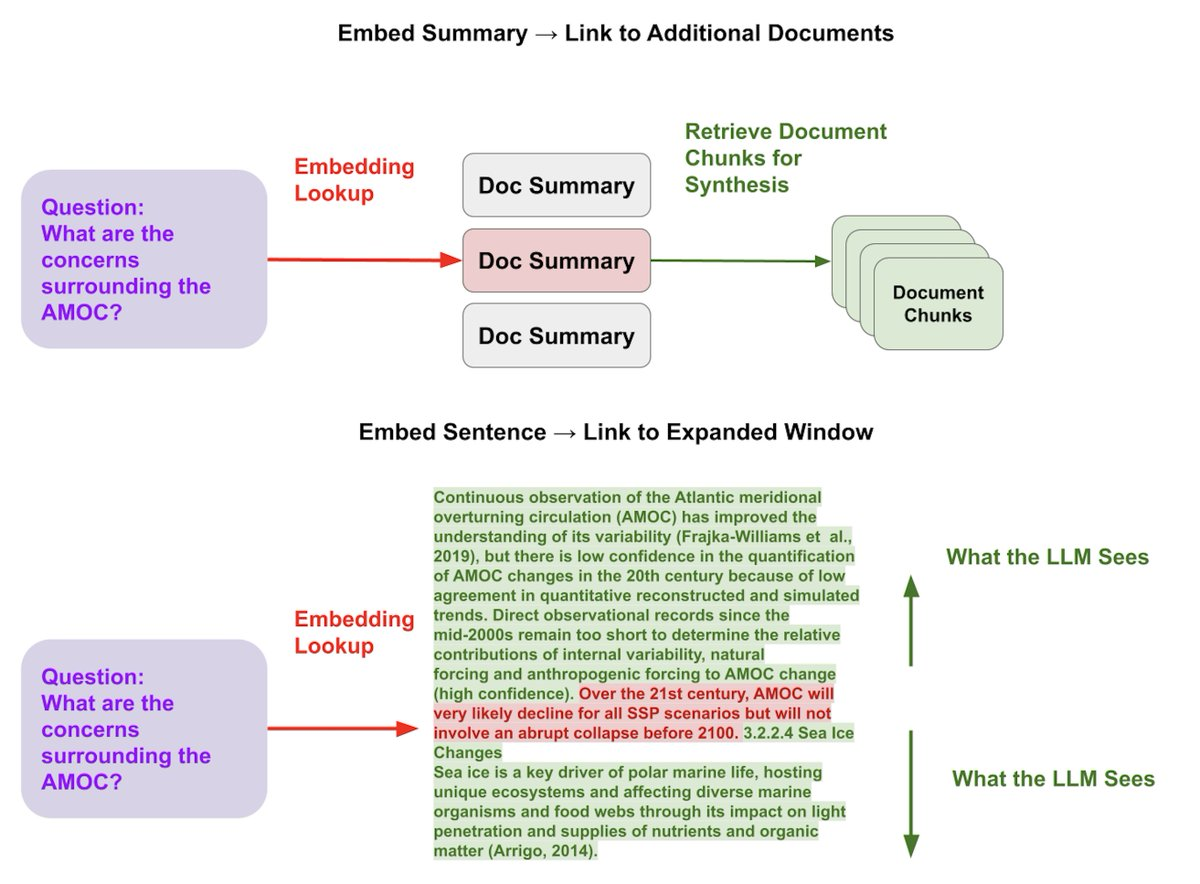

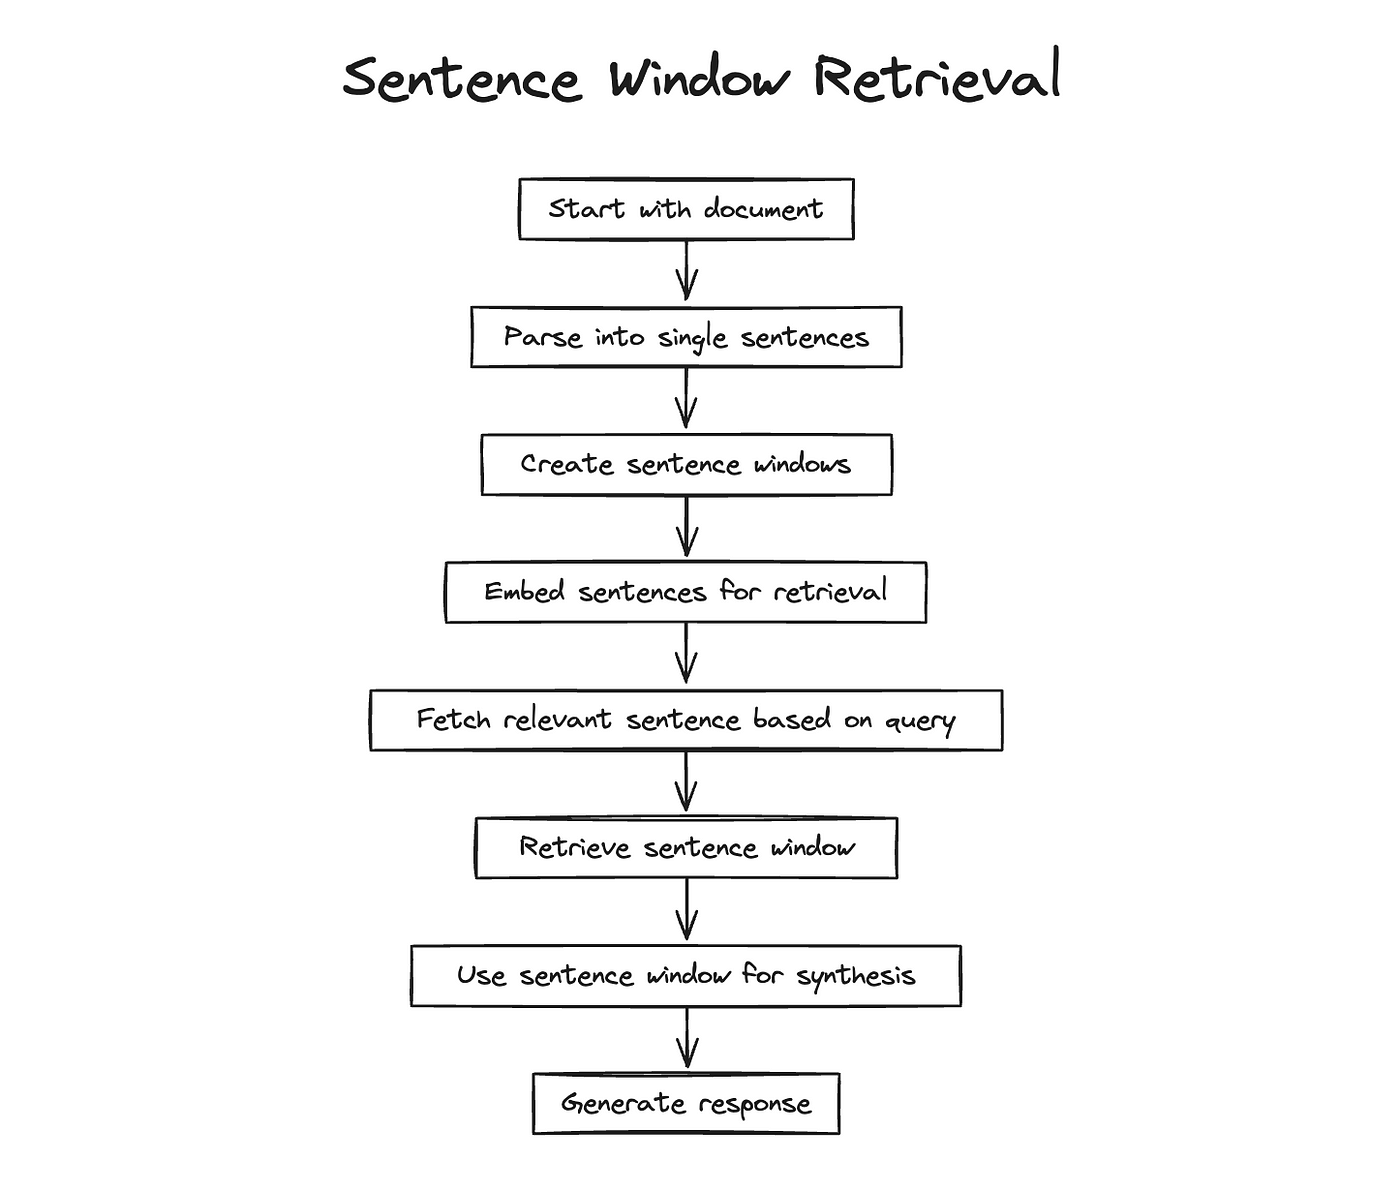

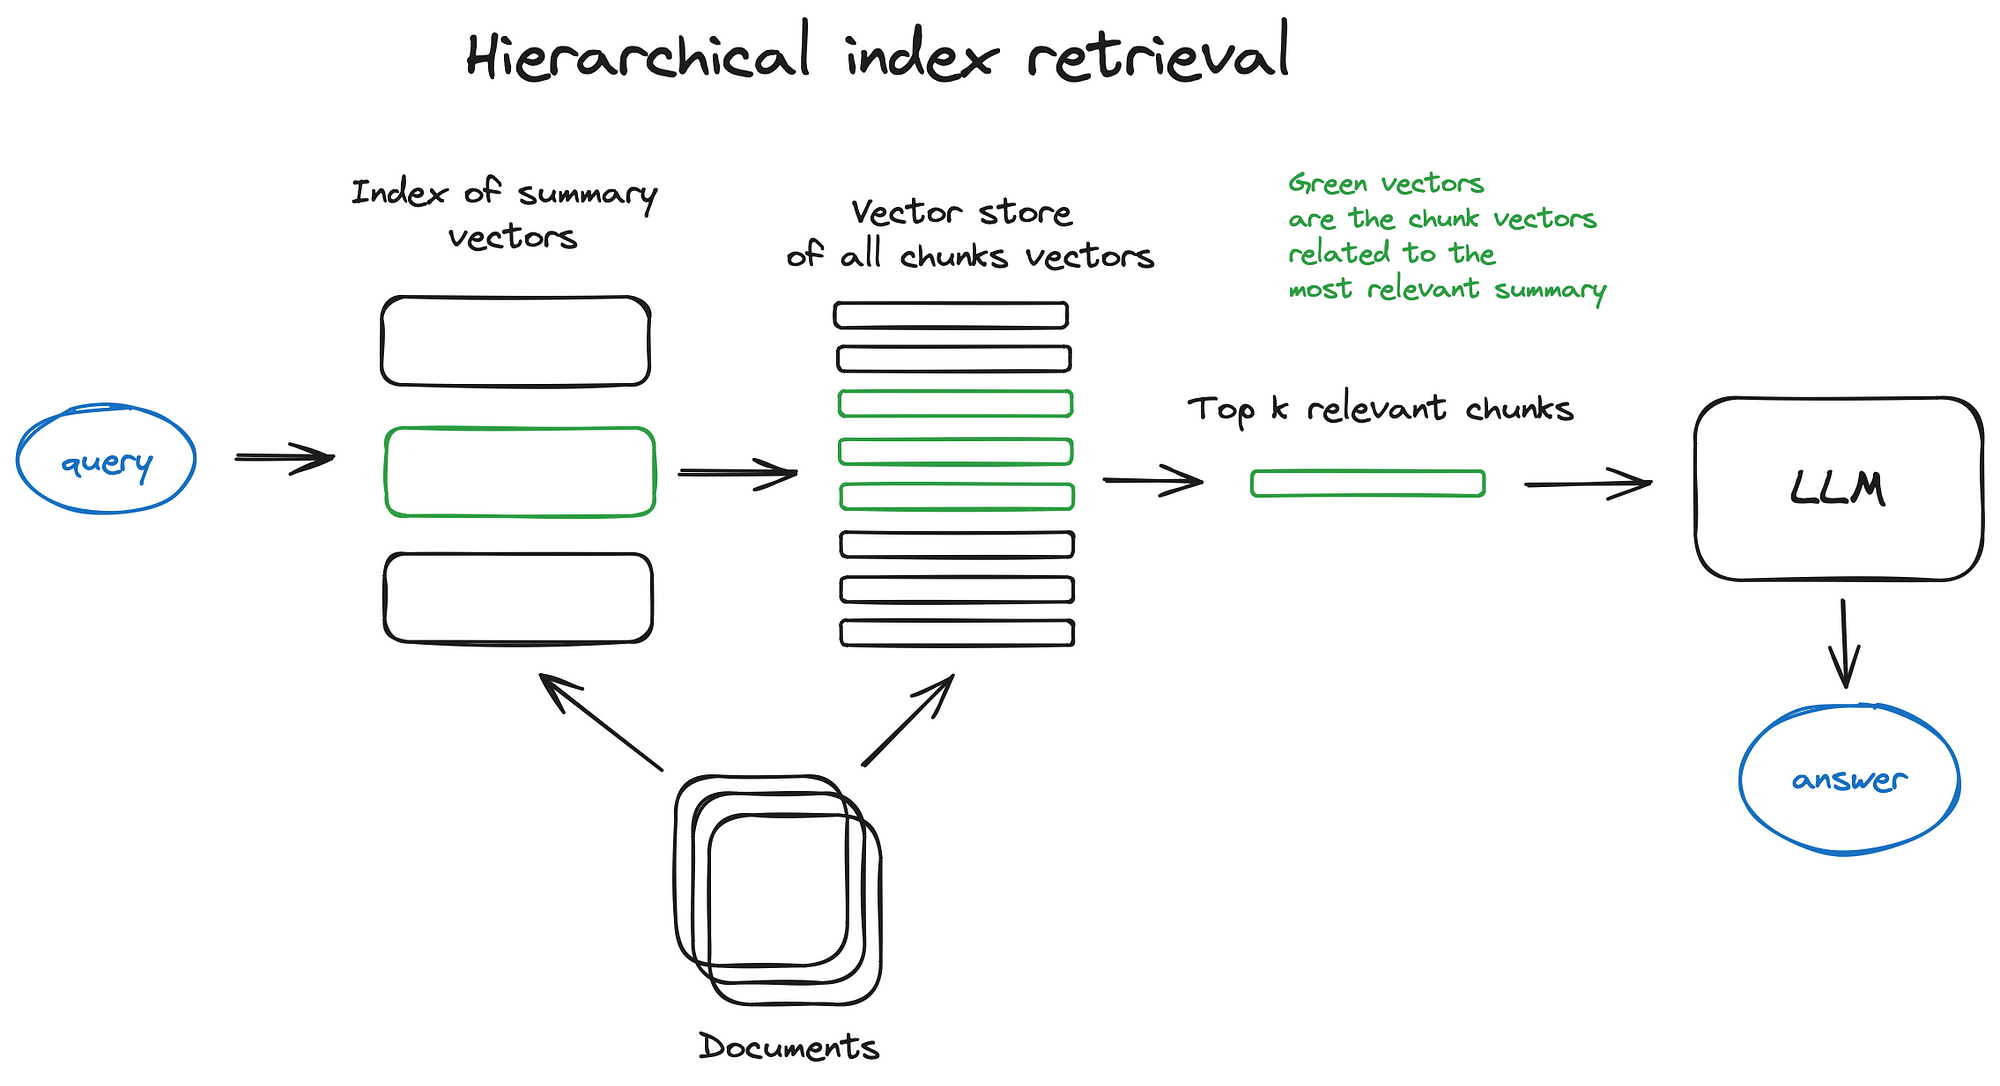

In [2]:

import os
import sys
import pprint

In [3]:
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    load_index_from_storage,
    StorageContext,
    ServiceContext,
    Document)

In [4]:

from llama_index.core.node_parser import SentenceWindowNodeParser

In [5]:

from llama_index.core.text_splitter import SentenceSplitter

In [6]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

d:\a27_YEARS_OLD\RAG_ranking\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from llama_index.core.schema import MetadataMode

In [8]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
# Loading embedding model
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-mpnet-base-v2", max_length=512) # token 512

In [23]:
embed_model

HuggingFaceEmbedding(model_name='sentence-transformers/all-mpnet-base-v2', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000014A7F610750>, num_workers=None, max_length=512, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None)

In [11]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv('GEMINI_API_KEY')  
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [12]:
import google.generativeai as genai
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.0-flash-exp
models/gemini-exp-1206
models/gemini-exp-1121
models/gemini-exp-1114
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/learnlm-1.5-pro-experimental


In [13]:
from llama_index.llms.gemini import Gemini
llm = Gemini(model="models/gemini-pro")

In [24]:
llm

Gemini(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000014A0F7CEB10>, system_prompt=None, messages_to_prompt=<function messages_to_prompt at 0x0000014A7F645B20>, completion_to_prompt=<function default_completion_to_prompt at 0x0000014A7F757B00>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=None, model='models/gemini-pro', temperature=0.1, max_tokens=2048, generate_kwargs={})

In [14]:

from llama_index.core.llms import ChatMessage
messages = [
    ChatMessage(role="user", content="Hello friend!"),
]

response = llm.chat(messages)
print(response)

assistant: Hello there! How can I assist you today?


In [15]:

documents = SimpleDirectoryReader(input_files=["data/bidenstateoftheunion.txt"]).load_data()

In [16]:
documents

[Document(id_='bfeb8874-b5b8-4b85-8266-b191f6b605a0', embedding=None, metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheunion.txt', 'file_type': 'text/plain', 'file_size': 25257, 'creation_date': '2025-01-16', 'last_modified_date': '2025-01-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='President Biden’s State of the Union Address\r\n(The President presents his prepared remarks to Speaker Johnson.) Your bedtime reading.\r\n\r\nTony! Thank you. Looking for Jill.\r\n\r\nGood evening. Good evening. If I were smart, I’d go home now.\r\n\r\nMr. Speaker, Madam Vice President, members of Congress, my fel

In [17]:

# Inspect the documents
print("length of doc: "+ str(len(documents)))
print("----")
#pprint(documents)

length of doc: 1
----


In [18]:

documents[0].metadata

{'file_path': 'data\\bidenstateoftheunion.txt',
 'file_name': 'bidenstateoftheunion.txt',
 'file_type': 'text/plain',
 'file_size': 25257,
 'creation_date': '2025-01-16',
 'last_modified_date': '2025-01-16'}

In [19]:
# create the sentence window node parser w/ default settings
sentence_node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text"
)  # child node

In [25]:
sentence_node_parser # for child nodes

SentenceWindowNodeParser(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000014A0148B0D0>, id_func=<function default_id_func at 0x0000014A7F7F1BC0>, sentence_splitter=<function split_by_sentence_tokenizer.<locals>.<lambda> at 0x0000014A11640EA0>, window_size=3, window_metadata_key='window', original_text_metadata_key='original_text')

In [20]:
nodes = sentence_node_parser.get_nodes_from_documents(documents)  # child nodes

In [26]:
nodes

[TextNode(id_='0f22750f-cc0a-4ef5-9746-b14a63c46241', embedding=None, metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheunion.txt', 'file_type': 'text/plain', 'file_size': 25257, 'creation_date': '2025-01-16', 'last_modified_date': '2025-01-16', 'window': 'President Biden’s State of the Union Address\r\n(The President presents his prepared remarks to Speaker Johnson.)  Your bedtime reading.\r\n\r\n Tony!  Thank you. ', 'original_text': 'President Biden’s State of the Union Address\r\n(The President presents his prepared remarks to Speaker Johnson.) '}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date', 'window', 'original_text'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='bfeb8874-b5b8-4b85-

In [ ]:
# SentenceWindowNodeParser
# This line creates an instance of SentenceWindowNodeParser using the from_defaults method, passing three arguments:
# window_size=3: The size of the sliding window used to parse sentences.
# window_metadata_key="window": The key used to store window metadata.
# original_text_metadata_key="original_text": The key used to store the original text metadata.
# Purpose
# The SentenceWindowNodeParser is designed to parse sentences into smaller windows of text, enabling more efficient processing and analysis.
# How it works:
# Splits the input text into individual sentences.
# Applies a sliding window of size window_size to each sentence.
# Extracts the text within each window and stores it as a node.
# Adds metadata to each node, including the window metadata and original text metadata.
# Benefits

In [21]:
base_node_parser = SentenceSplitter() # for parent nodes

In [27]:
base_node_parser

SentenceSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000014A1178F3D0>, id_func=<function default_id_func at 0x0000014A7F7F1BC0>, chunk_size=1024, chunk_overlap=200, separator=' ', paragraph_separator='\n\n\n', secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?')

In [22]:
base_nodes = base_node_parser.get_nodes_from_documents(documents) # parents nodes

In [28]:
base_nodes

[TextNode(id_='e1ad4f89-3a8a-4279-8e08-57bce4ca9234', embedding=None, metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheunion.txt', 'file_type': 'text/plain', 'file_size': 25257, 'creation_date': '2025-01-16', 'last_modified_date': '2025-01-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='bfeb8874-b5b8-4b85-8266-b191f6b605a0', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheunion.txt', 'file_type': 'text/plain', 'file_size': 25257, 'creation_date': '2025-01-16', 'last_modified_date': '2025-01-16'}, hash='b342058d10484404cb54d4409d4c3135052cf518da9a60a19981722e21e162cf'), <NodeRelationship.NEX

In [29]:

len(nodes) # children nodes

304

In [30]:

len(base_nodes) # parents nodes

7

In [32]:
print("---------")
print("SENTENCE NODES")
print("---------")
print(nodes[0])
print("---------")
print("BASE NODES")
print("---------")
print(base_nodes[0])

---------
SENTENCE NODES
---------
Node ID: 0f22750f-cc0a-4ef5-9746-b14a63c46241
Text: President Biden’s State of the Union Address  (The President
presents his prepared remarks to Speaker Johnson.)
---------
BASE NODES
---------
Node ID: e1ad4f89-3a8a-4279-8e08-57bce4ca9234
Text: President Biden’s State of the Union Address  (The President
presents his prepared remarks to Speaker Johnson.) Your bedtime
reading.    Tony! Thank you. Looking for Jill.    Good evening. Good
evening. If I were smart, I’d go home now.    Mr. Speaker, Madam Vice
President, members of Congress, my fellow Americans.    In January
1941, Franklin R...


In [33]:

nodes[0].text

'President Biden’s State of the Union Address\r\n(The President presents his prepared remarks to Speaker Johnson.) '

In [34]:
base_nodes[0].text

'President Biden’s State of the Union Address\r\n(The President presents his prepared remarks to Speaker Johnson.) Your bedtime reading.\r\n\r\nTony! Thank you. Looking for Jill.\r\n\r\nGood evening. Good evening. If I were smart, I’d go home now.\r\n\r\nMr. Speaker, Madam Vice President, members of Congress, my fellow Americans.\r\n\r\nIn January 1941, Franklin Roosevelt came to this chamber to speak to the nation. And he said, “I address you at a moment unprecedented in the history of the Union”. Hitler was on the march. War was raging in Europe.\r\n\r\nPresident Roosevelt’s purpose was to wake up Congress and alert the American people that this was no ordinary time. Freedom and democracy were under assault in the world.\r\n\r\nTonight, I come to the same chamber to address the nation. Now it’s we who face an unprecedented moment in the history of the Union.\r\n\r\nAnd, yes, my purpose tonight is to wake up the Congress and alert the American people that this is no ordinary moment ei

In [35]:
dict(nodes[0])

{'id_': '0f22750f-cc0a-4ef5-9746-b14a63c46241',
 'embedding': None,
 'metadata': {'file_path': 'data\\bidenstateoftheunion.txt',
  'file_name': 'bidenstateoftheunion.txt',
  'file_type': 'text/plain',
  'file_size': 25257,
  'creation_date': '2025-01-16',
  'last_modified_date': '2025-01-16',
  'window': 'President Biden’s State of the Union Address\r\n(The President presents his prepared remarks to Speaker Johnson.)  Your bedtime reading.\r\n\r\n Tony!  Thank you. ',
  'original_text': 'President Biden’s State of the Union Address\r\n(The President presents his prepared remarks to Speaker Johnson.) '},
 'excluded_embed_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date',
  'window',
  'original_text'],
 'excluded_llm_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date',
  'window',
  'original_text'],
 'relationships': {<NodeRelationship.SO

In [36]:
dict(base_nodes[0])

{'id_': 'e1ad4f89-3a8a-4279-8e08-57bce4ca9234',
 'embedding': None,
 'metadata': {'file_path': 'data\\bidenstateoftheunion.txt',
  'file_name': 'bidenstateoftheunion.txt',
  'file_type': 'text/plain',
  'file_size': 25257,
  'creation_date': '2025-01-16',
  'last_modified_date': '2025-01-16'},
 'excluded_embed_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'excluded_llm_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'relationships': {<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='bfeb8874-b5b8-4b85-8266-b191f6b605a0', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheunion.txt', 'file_type': 'text/plain', 'file_size': 25257, 'creation_date': '2025-01-16', 'last_modified_date': '2025-01-16'}, hash='b342058d10484404cb54d4409d4c3135052cf518da9a6

In [38]:
from llama_index.core import Settings

In [40]:
Settings.llm = llm
Settings.embed_model = embed_model
Settings.node_parser  = sentence_node_parser # for child nodes
Settings.text_splitter = base_node_parser # for parent nodes


In [49]:
Settings

_Settings(_llm=Gemini(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000014A114A8150>, system_prompt=None, messages_to_prompt=<function messages_to_prompt at 0x0000014A7F645B20>, completion_to_prompt=<function default_completion_to_prompt at 0x0000014A7F757B00>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=None, model='models/gemini-pro', temperature=0.1, max_tokens=2048, generate_kwargs={}), _embed_model=HuggingFaceEmbedding(model_name='sentence-transformers/all-mpnet-base-v2', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000014A114A8150>, num_workers=None, max_length=512, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None), _callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000014A114A8150>, _tokenizer=None, _node_parser=SentenceSplitter(include_metadata=True, include_prev_next_rel

In [41]:
# ctx_sentence = ServiceContext.from_defaults(llm=llm, embed_model=embed_model, node_parser=sentence_node_parser)
# ctx_base = ServiceContext.from_defaults(llm=llm, embed_model=embed_model, node_parser=base_node_parser)

In [43]:
from qdrant_client import QdrantClient
import os
from dotenv import load_dotenv


qdrant_client = QdrantClient(
    url=os.getenv('QDRANT_URL'), 
    api_key=os.getenv("QDRANT_API_KEY"),
)

print(qdrant_client.get_collections())

collections=[]


In [48]:
qdrant_client

In [44]:
'''client = qdrant_client.QdrantClient(
    # you can use :memory: mode for fast and light-weight experiments,
    # it does not require to have Qdrant deployed anywhere
    # but requires qdrant-client >= 1.1.1
    # location=":memory:"
    # otherwise set Qdrant instance address with:
    # url="http://:"
    # otherwise set Qdrant instance with host and port:
    host="localhost",
    port=6333
    # set API KEY for Qdrant Cloud
    # api_key="",
)'''

'client = qdrant_client.QdrantClient(\n    # you can use :memory: mode for fast and light-weight experiments,\n    # it does not require to have Qdrant deployed anywhere\n    # but requires qdrant-client >= 1.1.1\n    # location=":memory:"\n    # otherwise set Qdrant instance address with:\n    # url="http://:"\n    # otherwise set Qdrant instance with host and port:\n    host="localhost",\n    port=6333\n    # set API KEY for Qdrant Cloud\n    # api_key="",\n)'

In [45]:
from llama_index.vector_stores.qdrant import QdrantVectorStore

In [46]:
vector_store = QdrantVectorStore(client=qdrant_client, collection_name="state_of_uni") # child vector stores

In [47]:
vector_store # child vector stores

QdrantVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=False, collection_name='state_of_uni', url=None, api_key=None, batch_size=64, parallel=1, max_retries=3, client_kwargs={}, enable_hybrid=False, index_doc_id=True, fastembed_sparse_model=None, text_key='text')

In [50]:
vector_store2 = QdrantVectorStore(client=qdrant_client, collection_name="state_of_uni_base") # parent vector stores

In [51]:
vector_store2

QdrantVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=False, collection_name='state_of_uni_base', url=None, api_key=None, batch_size=64, parallel=1, max_retries=3, client_kwargs={}, enable_hybrid=False, index_doc_id=True, fastembed_sparse_model=None, text_key='text')

In [52]:

storage_context_child = StorageContext.from_defaults(vector_store=vector_store)

In [55]:
storage_context_child

StorageContext(docstore=<llama_index.core.storage.docstore.simple_docstore.SimpleDocumentStore object at 0x0000014A16EC1BD0>, index_store=<llama_index.core.storage.index_store.simple_index_store.SimpleIndexStore object at 0x0000014A153E72D0>, vector_stores={'default': QdrantVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=False, collection_name='state_of_uni', url=None, api_key=None, batch_size=64, parallel=1, max_retries=3, client_kwargs={}, enable_hybrid=False, index_doc_id=True, fastembed_sparse_model=None, text_key='text'), 'image': SimpleVectorStore(stores_text=False, is_embedding_query=True, data=SimpleVectorStoreData(embedding_dict={}, text_id_to_ref_doc_id={}, metadata_dict={}))}, graph_store=<llama_index.core.graph_stores.simple.SimpleGraphStore object at 0x0000014A183B18D0>, property_graph_store=None)

In [ ]:
# StorageContext
# This line creates a StorageContext instance for a child node, using the from_defaults method.
# Parameters
# vector_store=vector_store: The vector store to be used for storing and retrieving vector embeddings.
# Purpose
# The StorageContext provides a context for storing and retrieving data in a vector store. In this case, it's being used for a child node, which suggests that it's part of a hierarchical or nested data structure.

In [53]:
storage_context_parent = StorageContext.from_defaults(vector_store=vector_store2)

In [56]:
storage_context_parent

StorageContext(docstore=<llama_index.core.storage.docstore.simple_docstore.SimpleDocumentStore object at 0x0000014A18205CD0>, index_store=<llama_index.core.storage.index_store.simple_index_store.SimpleIndexStore object at 0x0000014A183B3F50>, vector_stores={'default': QdrantVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=False, collection_name='state_of_uni_base', url=None, api_key=None, batch_size=64, parallel=1, max_retries=3, client_kwargs={}, enable_hybrid=False, index_doc_id=True, fastembed_sparse_model=None, text_key='text'), 'image': SimpleVectorStore(stores_text=False, is_embedding_query=True, data=SimpleVectorStoreData(embedding_dict={}, text_id_to_ref_doc_id={}, metadata_dict={}))}, graph_store=<llama_index.core.graph_stores.simple.SimpleGraphStore object at 0x0000014A183B2650>, property_graph_store=None)

In [57]:
index_child = VectorStoreIndex.from_documents(documents, storage_context=storage_context_child) # ,service_context=ctx_sentence

In [58]:
index_parent = VectorStoreIndex.from_documents(documents,storage_context=storage_context_parent) # ,service_context=ctx_base

In [59]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

In [60]:
sentence_query_engine = index_child.as_query_engine(
    similarity_top_k=3,
    verbose=True,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window") # sentence node_parser
    ],
)

In [62]:
sentence_query_engine

In [61]:
base_query_engine = index_parent.as_query_engine(
    similarity_top_k=3,
    verbose=True
)

In [63]:
base_query_engine

In [65]:
question = "What president Biden said about Franklin Roosevelt ?"

In [66]:
base_response = base_query_engine.query(
    question
)

In [67]:
base_response

Response(response='President Biden said that Franklin Roosevelt came to the same chamber in January 1941 to speak to the nation and said, "I address you at a moment unprecedented in the history of the Union".', source_nodes=[NodeWithScore(node=TextNode(id_='8b7201a3-9e1f-4573-a9e6-30518133f69a', embedding=None, metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheunion.txt', 'file_type': 'text/plain', 'file_size': 25257, 'creation_date': '2025-01-16', 'last_modified_date': '2025-01-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='bfeb8874-b5b8-4b85-8266-b191f6b605a0', node_type='4', metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheun

In [68]:
print(base_response)

President Biden said that Franklin Roosevelt came to the same chamber in January 1941 to speak to the nation and said, "I address you at a moment unprecedented in the history of the Union".


In [69]:
sentence_response = sentence_query_engine.query(
    question
)

In [70]:
sentence_response

Response(response='President Biden said that Franklin Roosevelt came to the same chamber in January 1941 to speak to the nation and said, "I address you at a moment unprecedented in the history of the Union".', source_nodes=[NodeWithScore(node=TextNode(id_='5502f7f8-63a4-47a7-add5-d6fa5ebeefb0', embedding=None, metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheunion.txt', 'file_type': 'text/plain', 'file_size': 25257, 'creation_date': '2025-01-16', 'last_modified_date': '2025-01-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='bfeb8874-b5b8-4b85-8266-b191f6b605a0', node_type='4', metadata={'file_path': 'data\\bidenstateoftheunion.txt', 'file_name': 'bidenstateoftheun

In [71]:
print(sentence_response)

President Biden said that Franklin Roosevelt came to the same chamber in January 1941 to speak to the nation and said, "I address you at a moment unprecedented in the history of the Union".
